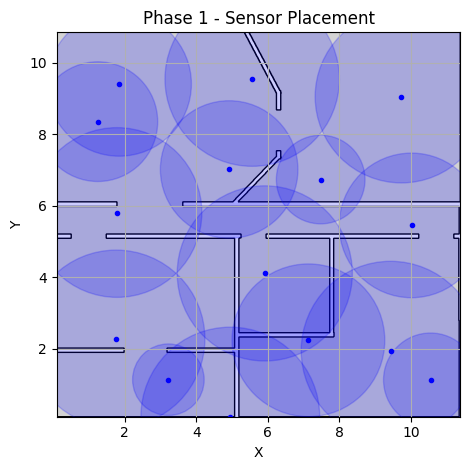

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
folder_path = "/content/drive/My Drive/notebook/layout.json"

# --------------------- Imports ---------------------
import numpy as np
import matplotlib.pyplot as plt
import json
from matplotlib.patches import Polygon
from matplotlib.path import Path
import os
import random

# --------------------- Load Layout ---------------------
with open(folder_path, "r") as f:
    layout_data = json.load(f)

polygon_coords = layout_data["verts"]
min_x, min_y = layout_data["bbox"]["min"]
max_x, max_y = layout_data["bbox"]["max"]
layout_poly = Path(polygon_coords)

# --------------------- Parameters ---------------------
num_particles = 30
num_iterations = 80
w_inertia = 0.7
c1, c2 = 1.4, 1.4

ga_generations = 5
mutation_rate = 0.1

num_sensors = 15
w_overlap = 2.0
w_overlap_pts = 1.0
w_radius = 0.1
sensor_radius_bounds = (1.0, 2.5)

# --------------------- Prepare Grid ---------------------
grid_resolution = 0.2
x_coords = np.arange(min_x, max_x, grid_resolution)
y_coords = np.arange(min_y, max_y, grid_resolution)
xx, yy = np.meshgrid(x_coords, y_coords)
GRID = np.c_[xx.ravel(), yy.ravel()]
valid = layout_poly.contains_points(GRID)

# --------------------- Fitness Function ---------------------
def evaluate_solution(sol):
    cov = np.zeros(len(GRID), dtype=int)
    radius_cost = 0.0
    for i in range(num_sensors):
        x, y, r = sol[3*i:3*i+3]
        if not layout_poly.contains_point((x, y)):
            return np.inf
        d = np.hypot(GRID[:, 0] - x, GRID[:, 1] - y)
        mask = (d <= r)
        cov += mask.astype(int)
        radius_cost += r
    cov = cov * valid
    unique_cov = np.sum(cov > 0)
    overlap_cov = np.sum(cov) - unique_cov
    overlap_pts = np.sum(cov > 1)
    fitness = (
        - unique_cov
        + w_overlap * overlap_cov
        + w_overlap_pts * overlap_pts
        + w_radius * radius_cost
    )
    return fitness

# --------------------- PSO + GA Setup ---------------------
dim = num_sensors * 3
lb = np.tile([min_x, min_y, sensor_radius_bounds[0]], num_sensors)
ub = np.tile([max_x, max_y, sensor_radius_bounds[1]], num_sensors)

pos = np.random.uniform(lb, ub, (num_particles, dim))
pos = np.random.uniform(lb, ub, (num_particles, dim))
vel = np.zeros_like(pos)
pbest = pos.copy()
pval = np.array([evaluate_solution(p) for p in pos])
gbest = pbest[np.argmin(pval)].copy()
gval = np.min(pval)

# Initialize tracking
gbest_history = [gbest.copy()]
fitness_per_iter = []
coverage_per_iter = []
cost_per_iter = []

# --------------------- Hybrid PSO + GA Loop ---------------------
for _ in range(num_iterations):
    for i in range(num_particles):
        r1, r2 = np.random.rand(dim), np.random.rand(dim)
        vel[i] = (
            w_inertia * vel[i]
            + c1 * r1 * (pbest[i] - pos[i])
            + c2 * r2 * (gbest - pos[i])
        )
        pos[i] += vel[i]
        pos[i] = np.minimum(np.maximum(pos[i], lb), ub)
        f = evaluate_solution(pos[i])
        if f < pval[i]:
            pval[i] = f
            pbest[i] = pos[i].copy()
            if f < gval:
                gval = f
                gbest = pos[i].copy()

    # GA refinement
    for _ in range(ga_generations):
        i1, i2 = np.random.choice(num_particles, 2, replace=False)
        p1, p2 = pbest[i1], pbest[i2]
        cp = np.random.randint(1, dim)
        child = np.concatenate([p1[:cp], p2[cp:]])
        m = np.random.rand(dim) < mutation_rate
        child[m] += np.random.normal(scale=0.1, size=m.sum()) * (ub[m] - lb[m])
        child = np.minimum(np.maximum(child, lb), ub)
        f_child = evaluate_solution(child)
        if f_child < gval:
            gval = f_child
            gbest = child.copy()

    # Record current best metrics
    cov = np.zeros(len(GRID), dtype=int)
    radius_cost = 0.0
    for i in range(num_sensors):
        x, y, r = gbest[3*i:3*i+3]
        d = np.hypot(GRID[:, 0] - x, GRID[:, 1] - y)
        mask = (d <= r)
        cov += mask.astype(int)
        radius_cost += r
    cov = cov * valid
    unique_cov = np.sum(cov > 0)
    overlap_cov = np.sum(cov) - unique_cov
    overlap_pts = np.sum(cov > 1)
    fitness = (
        - unique_cov
        + w_overlap * overlap_cov
        + w_overlap_pts * overlap_pts
        + w_radius * radius_cost
    )
    fitness_per_iter.append(fitness)
    coverage_per_iter.append(unique_cov)
    cost_per_iter.append(radius_cost)
    gbest_history.append(gbest.copy())

# --------------------- Save Phase 1 result ---------------------
sensor_positions = []
for i in range(num_sensors):
    x, y, r = gbest[3*i:3*i+3]
    sensor_positions.append([x, y, r])

with open("phase1_sensors.json", "w") as f:
    json.dump({"sensors": sensor_positions}, f, indent=2)

# --------------------- Final Layout Visualization ---------------------
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect("equal")
ax.add_patch(Polygon(polygon_coords, closed=True, facecolor="lightgray", edgecolor="black"))
for x, y, r in sensor_positions:
    ax.add_patch(plt.Circle((x, y), r, color='blue', alpha=0.3))
    ax.plot(x, y, 'bo', markersize=3)
plt.title("Phase 1 – PSO+GA with Strong Overlap Penalty")
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.xlabel("X"); plt.ylabel("Y")
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------- Convergence Plots ---------------------
fig, axs = plt.subplots(3, 1, figsize=(6, 12))

axs[0].plot(coverage_per_iter, color='steelblue')
axs[0].set_title("Coverage Area per Iteration")
axs[0].set_ylabel("Coverage")
axs[0].grid(True)

axs[1].plot(cost_per_iter, color='orange')
axs[1].set_title("Total Cost per Iteration")
axs[1].set_ylabel("Cost")
axs[1].grid(True)

axs[2].plot(fitness_per_iter, color='green')
axs[2].set_title("Fitness Score per Iteration")
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("Fitness")
axs[2].grid(True)

plt.tight_layout()
plt.show()
